In [1]:
import numpy as np
from wavefunctions import *
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

In [2]:
def information(datapack, electronic_structure_data, Z):
    '''
    Input:
        datapack: dataframe
            Dataset containing data for every element.
        electronic_structure: dataframe
            Dataset containing the electronic structure data of each element.
        Z: int
            The atomic number Z of the desired element.
    Output:
        Sr: float
            Shannon information entropy in position space.
        Sk: float
            Shannon information entropy in momentum space.
        S: float
            Total information entropy.
        Smax: float
            Maxixmum entropy accessible to the system.
        Omega: float
            Landsberg's order parameter Omega.
        O: float
            Onicescu information. 
    '''
    df = datapack[datapack['Z']== Z]
    e_struct = np.array(electronic_structure_data[electronic_structure_data['Z']==Z].drop(columns='Z'))[0]
    
    def creating_Rij(df):
        '''
        This function creates the function of a radial atomic orbital of an element.
        Input:
            df: dataframe
                Dataset containing the orbital data of an element.
        Output:
            function of the atomic orbital Rij.
        '''
        n = len(df) # length of dataframe
        sto = np.array(df['sto']) # STO orbitals array.
        zeff = np.array(df['zeff']) # Z array.
        coeff = np.array(df['coeff']) # Coefficient array.
        f = [] # where every STO orbital of the radial orbital is stored.
        for i in range(n): # for every element of the list.
            # Each appended element is a lambda function of a STO orbital.
            # Sr_orb is a dictionary on wavefunction.py, from a name of the STO database
            # as key, it returns the name of the STO function.
            f.append(lambda r, z=zeff[i], c=coeff[i], sto = sto[i]: c*Sr_orb[sto](z,r))

        # adding all the elements of f for the value r=r.
        def Rij(r,f):
            res=0
            for func in f:
                res = res + func(r)
            return res

        return (lambda r, f=f: Rij(r,f))
    
    def creating_Kij(df):
        '''
        Same function as creating_Rij, but it is on the momentum space.
        '''
        n = len(df)
        sto = np.array(df['sto'])
        zeff = np.array(df['zeff'])
        coeff = np.array(df['coeff'])
        f = []
        for i in range(n):
            f.append(lambda k, z=zeff[i], c=coeff[i], sto = sto[i]: c*Sk_orb[sto](z,k))

        def Kij(k,f):
            res=0
            for func in f:
                res = res + func(k)
            return res

        return (lambda k, f=f: Kij(k,f))  
    
    def return_pr(el_struct,df):
        '''
        This function uses the function creating_Rij in order to compute rho(r).
        Input:
            el_struct: dataframe
                Dataset containting the electronic structure data.
            df: dataframe
                Dataset containing the orbital data of an element.
        Output:
            lambda function: density distribution
        '''
        name_of_orbitals = df['orb'].unique() # obtaining the unique Orbitals.
        R = [] # where the radial orbitals will be stored.
        for i in name_of_orbitals: # for every orbital
            R.append(creating_Rij(df[df['orb']==i])) # append the Rij radial function.

        def pr(R, el_struct,r): # add every element of R into a single function.
            res = 0
            for i in range(len(R)):
                # el_struct[i] gives the number of electrons on that orbital.
                res = res + el_struct[i]*R[i](r)**2 
            return 1/(4*np.pi*sum(el_struct))*res

        return lambda r: pr(R,el_struct,r)
    
    def return_nk(el_struct,df):
        '''
        Same function as return_pr but on the momentum space.
        '''
        name_of_orbitals = df['orb'].unique()
        R = []
        for i in name_of_orbitals:
            R.append(creating_Kij(df[df['orb']==i]))

        def nk(R, el_struct,k):
            res = 0
            for i in range(len(R)):
                res = res + el_struct[i]*R[i](k)**2
            return 1/(4*np.pi*sum(el_struct))*res

        return lambda k: nk(R,el_struct,k)
    
    Pr = return_pr(e_struct,df) # setting Pr as the density distribution.
    Nk = return_nk(e_struct,df) # setting Nk as the density distribution at momentum space.
    
    # Calculating Shannon's information entropy.
    def information_entropy(pr):
        return -4*np.pi*quad(lambda r: pr(r)*np.log(pr(r))*r**2 ,0,250)[0] 
    
    Sr = information_entropy(Pr) # Sr
    Sk = information_entropy(Nk) # Sk
    S = Sr + Sk # Total information entropy.
    
    # Calculating max entropy accessible to the system.
    def Smaximum(pr,nk):
        r2 = 4*np.pi*quad(lambda r: pr(r)*r**4,0,np.inf)[0]
        k2 = 4*np.pi*quad(lambda k: nk(k)*k**4,0,np.inf)[0]
        return 3*(1+np.log(np.pi)) + 3/2 * np.log(4/9 * r2*k2)
    
    Smax = Smaximum(Pr,Nk) # Smax
    Omega = 1 - S/Smax # Landsberg's order parameter Omega.
    
    #  Calculating Onicescu's Informational Entropy.
    def Onicescu(pr, nk):
        er = 4*np.pi*quad(lambda r: pr(r)**2 * r**2 ,0,np.inf)[0]
        ek = 4*np.pi*quad(lambda k: nk(k)**2 * k**2 ,0,np.inf)[0]
        return 1/(er*ek)
        
    O = Onicescu(Pr,Nk)
    
    return [Sr,Sk,S,Smax,Omega,O]

In [3]:
# Reading the data files.
datapack = pd.read_excel('df.xlsx') 
electronic_structure_data = pd.read_excel('electronic_structures.xlsx')

In [18]:
s = np.zeros([9,7]) # Storing 
for i in range(9):
    s[i] = int(i+2)
    s[i, 1:] = information(datapack,electronic_structure_data, i+2)

In [19]:
s_df = pd.DataFrame(s)
s_df.columns = ['Z','Sr', 'Sk', 'S', 'Smax', 'Omega', 'O']

In [20]:
s_df

,Z,Sr,Sk,S,Smax,Omega,O
0,2.0,2.698511,3.913419,6.611930,7.049299,0.062044,100.361326
1,3.0,3.701437,3.996819,7.698256,10.357839,0.256770,9.157127
2,4.0,3.623859,4.190188,7.814047,10.395028,0.248290,8.454339
3,5.0,3.405445,4.705902,8.111347,10.373844,0.218096,15.965316
4,6.0,3.106025,5.156576,8.262601,10.262419,0.194868,25.712130
5,7.0,2.801688,5.549337,8.351025,10.151972,0.177399,37.431982
6,8.0,2.550539,5.867353,8.417892,10.111271,0.167474,48.483769
7,9.0,2.298827,6.163324,8.462151,10.053278,0.158269,61.145004
8,10.0,2.055138,6.437067,8.492205,9.990766,0.149995,75.244712


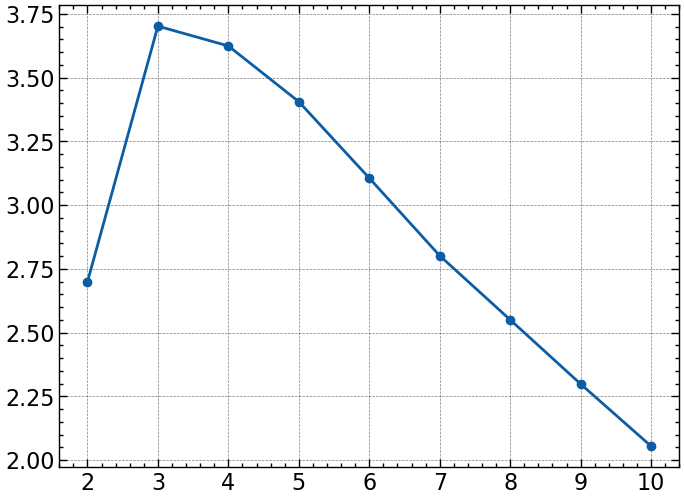

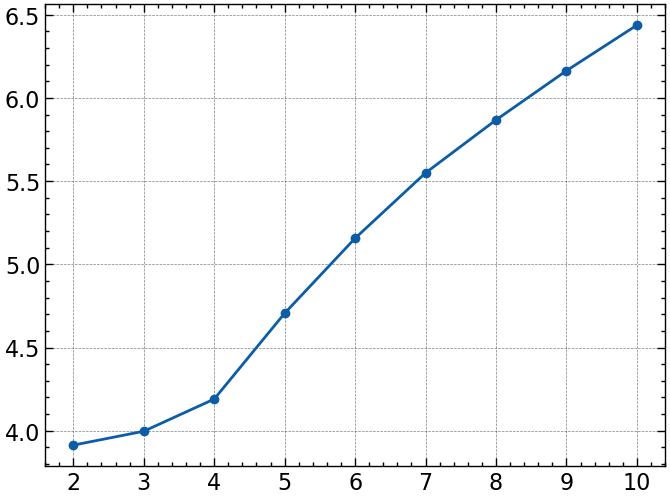

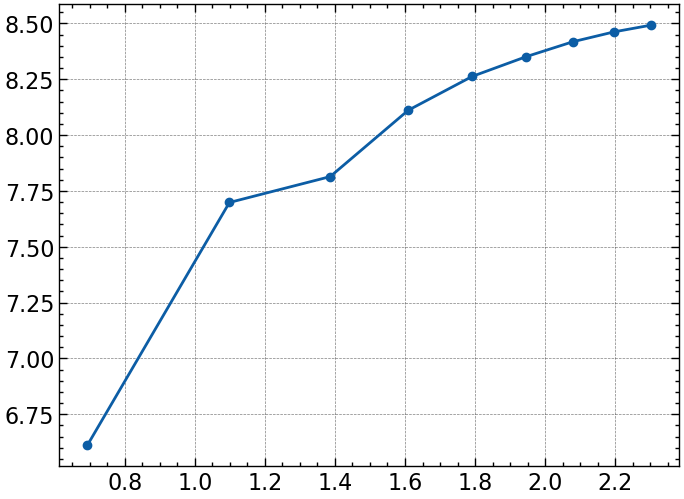

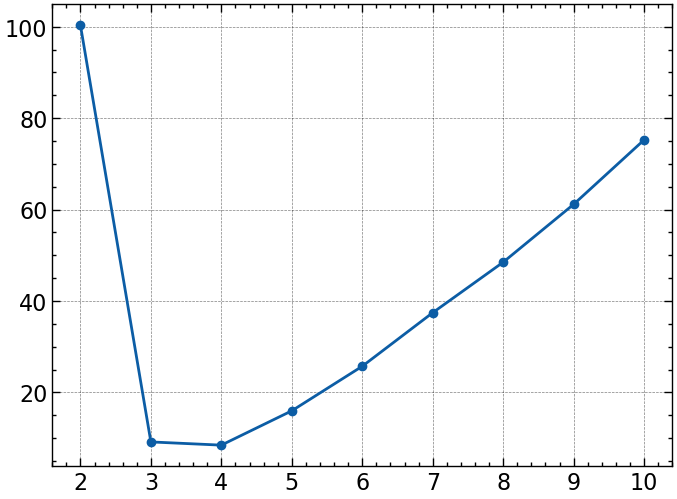

In [6]:
z = np.arange(2,11)
plt.plot(z,s[:,0],'o-')
plt.show()
plt.plot(z,s[:,1],'o-')
plt.show()
plt.plot(np.log(z),s[:,2],'o-')
plt.show()
plt.plot(z,s[:,-1],'o-')
plt.show()

In [7]:
ion_pot = pd.read_excel('ion_pot.xlsx')
ion_pot.head()

,Z,IonEn(eV)
0,2,24.587
1,3,5.392
2,4,9.323
3,5,8.298
4,6,11.260


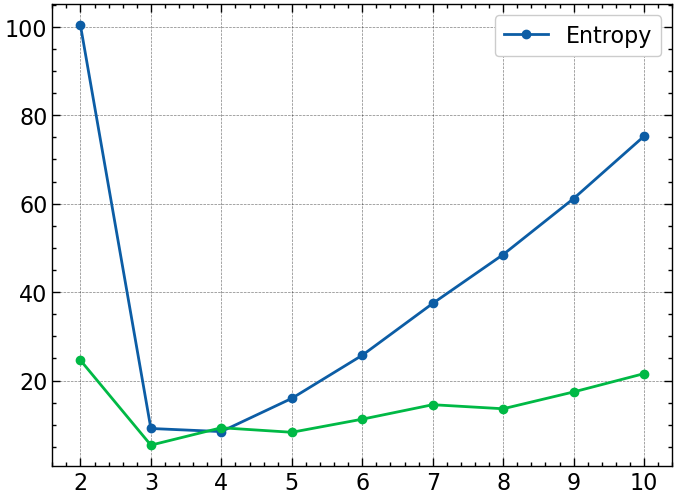

In [8]:
plt.plot(z,s[:,-1],'o-',label='Entropy')
plt.plot(z,ion_pot['IonEn(eV)'],'o-')
plt.legend()